[View in Colaboratory](https://colab.research.google.com/github/thimotio/ExpertSystem/blob/master/Froth_Flotation_Fuzzy_Control_v01.ipynb)

# Fuzzy Control Systems: Iron Ore Froth Flotation


# Disclaimer

This code was created for the educational purpose and sharing of advanced control techniques.

For application in real cases of process in the industry it is necessary to model the controls as well as to identify the limits and interrelations of the variables to guarantee operational safety.

**Authors are not responsible** for the results of using this code without due precautions.

---

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Flotation_cell.jpg/450px-Flotation_cell.jpg)

##The Froth Flotation 
[wikipedia](https://en.wikipedia.org/wiki/Froth_flotation)

> Froth flotation is a process for selectively separating hydrophobic materials from hydrophilic. This is used in mineral processing, paper recycling and waste-water treatment industries. Historically this was first used in the mining industry, where it was one of the great enabling technologies of the 20th century. It has been described as "the single most important operation used for the recovery and upgrading of sulfide ores".[1] The development of froth flotation has improved the recovery of valuable minerals, such as copper- and lead-bearing minerals. Along with mechanized mining, it has allowed the economic recovery of valuable metals from much lower grade ore than previously.


Foam flotation, or simply flotation, is a separation process applied to solid particles that exploits differences in surface characteristics between the various species present, treating heterogeneous mixtures of suspended particles in the aqueous phase in which a gas phase is introduced (Peres et al., 1980)

The reverse cationic flotation of iron ore has this name because it occurs in an inverse way, with the gangue the specimen floated. This gangue consists mainly of SiO2 particles with induced hydrophobic characteristics. Practically, it can be considered as a direct silica flotation.


> [1] G J Jameson, "Flotation cell development," in: The AusIMM Annual Conference, Broken Hill, New South Wales, 17–21 May 1992 (The Australasian Institute of Mining and Metallurgy: Melbourne, 1992), 25–31.


###Froth basic control - Iron Ore

Reverse quartz cationic flotation is the most commonly used itabirite iron ore concentration method for pellet feed production. Quartz is floated with etheramines partially neutralized with acetic acid and the iron minerals are depressed by unmodified starches.

Although widely used, this method has high complexity and the domain of current knowledge is consolidated in the interfacial properties that govern its dynamics and phenomenological models experienced in industrial practice.

There are several mineral and process variables that interfere with the dynamic behavior of flotation, and some of this knowledge is not completely elucidated. This is mainly due to the lack of means to measure specific properties that can explain more clearly its behavior in the face of the various interferences to which it is subject. This gap makes it very difficult to define more comprehensive models and that can represent in general the various flotation processes.

Flotation involves the recovery of minerals in two distinct phases. The pulp phase, composed mainly of a mixture of mineral particles and gangue in aqueous medium, can be adequately described by first order kinetics. The foam phase is mainly composed of bubbles and their lamellae, and no suitable general model exists to describe this phase. As a result, the first order kinetic model is usually imposed on the entire flotation process (Mathe et al., 1998).

The mechanism involved in the separation of the ore minerals and the gangue is possible thanks to the different properties of the mineral surfaces involved when in aqueous medium, at a certain pH. The addition of reagents with physicochemical characteristics capable of selectively modifying the surface properties of the minerals in relation to the solution, as well as the introduction of the gas phase into the system, creates conditions for the separation of the minerals.

In this context, the operational practice combined with the technical knowledge of the state of the art of flotation allows modeling, through knowledge-based control techniques (expert system) and the development of operating support systems that control the process variables according to pre-established rules.


# The Control Problem


---

## Control Description

Considering the typical iron ore flotation circuits we have 3 flotation steps with the aim of maximizing the metallic recovery and obtaining the necessary quality.

Below we have an industrial circuit with the 3 steps (Rougher, Cleaner and Scavenger) and the current load considering the closed circuit.

Two products are generated in this circuit: the flotation concentrate and the flotation reject.

The products are directed to thickeners for water recovery and suitability for later stages of the process

![alt text](https://github.com/thimotio/ExpertSystem/blob/master/Froth%20Flotation%20Circuit.jpg?raw=true)

Reagents are added to the feed to modulate the physicochemical characteristics of the pulp in order to obtain control of the desired specifications.

Flotation machines have foam layer and air flow level controls.

### The reagents are:

*   Soda Caustica: modulates the pH of the pulp
* Starch as the modifier in the process, preventing the amine collecting action on the iron particle
* Amina - acts as collector and sparklingList item

## Control Strategy

In this example we will consider the expert control of a Rougher column through the following variables:


Controlled Variable (control objective)

* Silica content in the concentrate


Manipulated Variables (the ones I modify to get the goal)

* Column Level
* Air Flow in the Column
* Amine Dosage
* Starch dosage

It is important to emphasize that this example is a simplification, and for the correct implementation one must consider all manipulated variables of the circuit in order to implement the control.

The expansion of this control can be performed from the concepts presented in this example.




# Expert System: Fuzzy Controler Design

Generally, expert systems evaluate the state of the process periodically (according to the control variables) and acts on the manipulated variables to correct any deviations.

For the controlled variable (PV) it is common to define a target objective (SP) and to correct the control error (SP - PV). Such a variable is called an **Error**.

> This error is evaluated by the operators as Low, Null or High.

In order to evaluate the dynamics of the process the operators also evaluate the tendency of the error (**Gradient**). In this case, the gradient is nothing more than the difference between two error values ​​in a time interval "d" (error (i) - error (i-d)) divided by time interval (delta t)

> This Gradient is evaluated by operators such as Falling, Stable, or Rising.

From the evaluation of the two information the control actions are taken as increments in the manipulated variables. The purpose of using increments is to move the operating point incrementally, without abrupt changes, however, in order to optimize the result.

* **Amine increase:** increasing the amine implies in reducing the silica error, however, it has a high cost
* **Increasing Air:** increasing the air has the objective of reducing the silica error. It acts on the dynamics of collecting the bubbles in the ore pulp and has a very low cost.
* **Level Increment:** raising the level aims to increase the error of the silica. It is related to the pulp balance in the circuit and its productivity (low error allows to increase the productivity in the circuit by opening the control valve and increasing the foam level)

For cost reduction an evaluation of the foam level will be inserted in order to increase the amine only if the level is above a low (<50%) level

In [0]:
!pip install -U scikit-fuzzy

'''Import modules'''
import numpy as np
import skfuzzy as fuzz #fuzzy controller module
import matplotlib 
import matplotlib.pyplot
from skfuzzy import control as ctrl



# Definition of membership funcions to Fuzzy Variables (controled and manipulated)

In [0]:
def NewAntecedentFuzzy_Exponencial(Name, vmin, vmax, precision, Curvas ):
  '''
   Defining membership function curves with S and Z Gaussian distribuctions
   
   Parameters:
    - Name: name of fuzzy variable
    - vmin: minumum value of distribuction
    - vmax: maximum value of distribuction
    - precision: math precision for calculation
    - Curves: Names of membership curves (3 or 5 names)
  '''
  #define the new Antecedent Fuzzy Variabel and set 
  FuzzyVar = ctrl.Antecedent(np.arange(vmin, vmax, precision), Name);
  #if the MF has 3 membership functions
  if np.size(Curvas) == 3:
      mean = np.abs(vmax - vmin)/2 + vmin
      std = np.abs(vmax - vmin)/6
      FuzzyVar[Curvas[0]] = fuzz.zmf(FuzzyVar.universe, vmin, mean)
      FuzzyVar[Curvas[1]] = fuzz.gaussmf(FuzzyVar.universe, mean, std )
      FuzzyVar[Curvas[2]] = fuzz.smf(FuzzyVar.universe, mean, vmax)

  if np.size(Curvas) == 5:
      mean = np.abs(vmax - vmin)/2 + vmin
      quarter1 = np.abs(vmax - vmin)/4 + vmin
      quarter2 = np.abs(vmax - vmin)/4 + mean
      std = np.abs(vmax - vmin)/12
      FuzzyVar[Curvas[0]] = fuzz.zmf(FuzzyVar.universe, vmin, quarter1)
      FuzzyVar[Curvas[1]] = fuzz.gaussmf(FuzzyVar.universe, quarter1, std )
      FuzzyVar[Curvas[2]] = fuzz.gaussmf(FuzzyVar.universe, mean, std )
      FuzzyVar[Curvas[3]] = fuzz.gaussmf(FuzzyVar.universe, quarter2, std )
      FuzzyVar[Curvas[4]] = fuzz.smf(FuzzyVar.universe, quarter2, vmax)


  return FuzzyVar

In [0]:
def NewConsequenceFuzzy_Triangular(Name, vmin, vmax, precision, Curvas ):
  '''
   Defining membership function curves with triangular distribuctions
   
   Parameters:
    - Name: name of fuzzy variable
    - vmin: minumum value of distribuction
    - vmax: maximum value of distribuction
    - precision: math precision for calculation
    - Curves: Names of membership curves (3 or 5 names)
  '''
  #define the new Antecedent Fuzzy Variabel and set 
  FuzzyVar = ctrl.Consequent(np.arange(vmin, vmax, precision), Name);
  #if the MF has 3 membership functions
  if np.size(Curvas) == 3:
      mean = np.abs(vmax - vmin)/2 + vmin
      FuzzyVar[Curvas[0]] = fuzz.trimf(FuzzyVar.universe, [vmin, vmin, mean] )
      FuzzyVar[Curvas[1]] = fuzz.trimf(FuzzyVar.universe, [vmin, mean, vmax] )
      FuzzyVar[Curvas[2]] = fuzz.trimf(FuzzyVar.universe, [mean, vmax, vmax] )

  if np.size(Curvas) == 5:
      mean = np.abs(vmax - vmin)/2 + vmin
      quarter1 = np.abs(vmax - vmin)/4 + vmin
      quarter2 = np.abs(vmax - vmin)/4 + mean
      FuzzyVar[Curvas[0]] = fuzz.trimf(FuzzyVar.universe, [vmin, vmin, quarter1])
      FuzzyVar[Curvas[1]] = fuzz.trimf(FuzzyVar.universe, [vmin, quarter1, mean] )
      FuzzyVar[Curvas[2]] = fuzz.trimf(FuzzyVar.universe, [quarter1, mean, quarter2] )
      FuzzyVar[Curvas[3]] = fuzz.trimf(FuzzyVar.universe, [mean, quarter2, vmax] )
      FuzzyVar[Curvas[4]] = fuzz.trimf(FuzzyVar.universe, [quarter2, vmax, vmax] )


  return FuzzyVar

## Creat Fuzzy Variables


---

Define the Antecedent variables (controled) and the Consequent variables (Manipulated)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


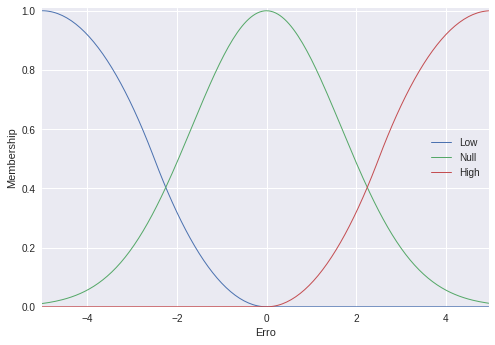

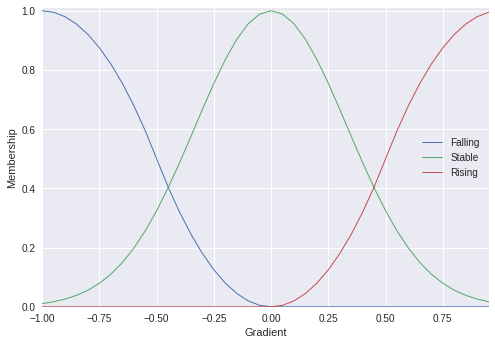

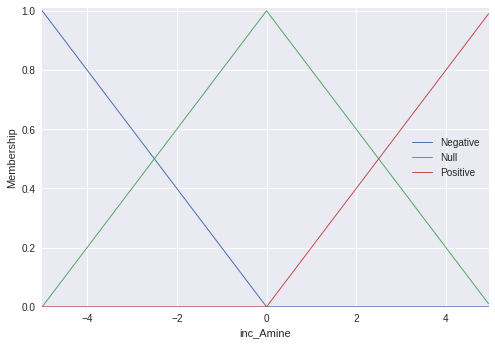

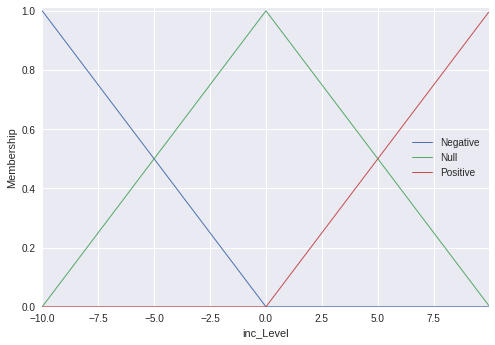

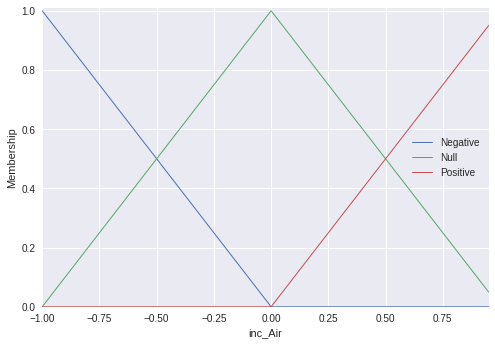

In [50]:
Names = ['Low', 'Null', 'High']
Erro = NewAntecedentFuzzy_Exponencial("Erro", -5, 5, 0.05, Names)
Level = NewAntecedentFuzzy_Exponencial("Level", 0, 100, 0.05, Names)
Erro.view()
Names = ['Falling' , 'Stable', 'Rising']
Gradient = NewAntecedentFuzzy_Exponencial("Gradient", -1, 1, 0.05, Names)
Gradient.view()
Names = ['Negative', 'Null', 'Positive']
inc_Amine = NewConsequenceFuzzy_Triangular("inc_Amine", -5, 5, 0.05, Names)
inc_Amine.view()
inc_Level = NewConsequenceFuzzy_Triangular("inc_Level", -10, 10, 0.05, Names)
inc_Level.view()
inc_Air = NewConsequenceFuzzy_Triangular("inc_Air", -1, 1, 0.05, Names)
inc_Air.view()



## Fuzzy Rules declaration


---



### Fuzzy rules


Now, to make these triangles useful, we define the *fuzzy relationship*
between input and output variables. For the purposes of our example, consider
three simple rules:

Most people would agree on these rules, but the rules are fuzzy. Mapping the
imprecise rules into a defined, actionable tip is a challenge. This is the
kind of task at which fuzzy logic excels.



<html xmlns:v="urn:schemas-microsoft-com:vml"
xmlns:o="urn:schemas-microsoft-com:office:office"
xmlns:w="urn:schemas-microsoft-com:office:word"
xmlns:x="urn:schemas-microsoft-com:office:excel"
xmlns:m="http://schemas.microsoft.com/office/2004/12/omml"
xmlns="http://www.w3.org/TR/REC-html40">

<head>
<meta http-equiv=Content-Type content="text/html; charset=windows-1252">
<meta name=ProgId content=Word.Document>
<meta name=Generator content="Microsoft Word 15">
<meta name=Originator content="Microsoft Word 15">
<link rel=File-List href="Air%20Increment_arquivos/filelist.xml">
<!--[if gte mso 9]><xml>
 <o:DocumentProperties>
  <o:Author>Flavio Thimotio da Silva</o:Author>
  <o:LastAuthor>Flavio Thimotio da Silva</o:LastAuthor>
  <o:Revision>1</o:Revision>
  <o:TotalTime>2</o:TotalTime>
  <o:Created>2018-10-01T14:08:00Z</o:Created>
  <o:LastSaved>2018-10-01T14:10:00Z</o:LastSaved>
  <o:Pages>1</o:Pages>
  <o:Words>14</o:Words>
  <o:Characters>78</o:Characters>
  <o:Lines>1</o:Lines>
  <o:Paragraphs>1</o:Paragraphs>
  <o:CharactersWithSpaces>91</o:CharactersWithSpaces>
  <o:Version>16.00</o:Version>
 </o:DocumentProperties>
 <o:OfficeDocumentSettings>
  <o:AllowPNG/>
 </o:OfficeDocumentSettings>
</xml><![endif]-->
<link rel=themeData href="Air%20Increment_arquivos/themedata.thmx">
<link rel=colorSchemeMapping
href="Air%20Increment_arquivos/colorschememapping.xml">
<!--[if gte mso 9]><xml>
 <w:WordDocument>
  <w:SpellingState>Clean</w:SpellingState>
  <w:GrammarState>Clean</w:GrammarState>
  <w:TrackMoves>false</w:TrackMoves>
  <w:TrackFormatting/>
  <w:HyphenationZone>21</w:HyphenationZone>
  <w:PunctuationKerning/>
  <w:ValidateAgainstSchemas/>
  <w:SaveIfXMLInvalid>false</w:SaveIfXMLInvalid>
  <w:IgnoreMixedContent>false</w:IgnoreMixedContent>
  <w:AlwaysShowPlaceholderText>false</w:AlwaysShowPlaceholderText>
  <w:DoNotPromoteQF/>
  <w:LidThemeOther>PT-BR</w:LidThemeOther>
  <w:LidThemeAsian>X-NONE</w:LidThemeAsian>
  <w:LidThemeComplexScript>X-NONE</w:LidThemeComplexScript>
  <w:Compatibility>
   <w:BreakWrappedTables/>
   <w:SnapToGridInCell/>
   <w:WrapTextWithPunct/>
   <w:UseAsianBreakRules/>
   <w:DontGrowAutofit/>
   <w:SplitPgBreakAndParaMark/>
   <w:EnableOpenTypeKerning/>
   <w:DontFlipMirrorIndents/>
   <w:OverrideTableStyleHps/>
  </w:Compatibility>
  <m:mathPr>
   <m:mathFont m:val="Cambria Math"/>
   <m:brkBin m:val="before"/>
   <m:brkBinSub m:val="&#45;-"/>
   <m:smallFrac m:val="off"/>
   <m:dispDef/>
   <m:lMargin m:val="0"/>
   <m:rMargin m:val="0"/>
   <m:defJc m:val="centerGroup"/>
   <m:wrapIndent m:val="1440"/>
   <m:intLim m:val="subSup"/>
   <m:naryLim m:val="undOvr"/>
  </m:mathPr></w:WordDocument>
</xml><![endif]--><!--[if gte mso 9]><xml>
 <w:LatentStyles DefLockedState="false" DefUnhideWhenUsed="false"
  DefSemiHidden="false" DefQFormat="false" DefPriority="99"
  LatentStyleCount="375">
  <w:LsdException Locked="false" Priority="0" QFormat="true" Name="Normal"/>
  <w:LsdException Locked="false" Priority="9" QFormat="true" Name="heading 1"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 2"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 3"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 4"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 5"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 6"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 7"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 8"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 9"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 7"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 8"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 9"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 1"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 2"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 3"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 4"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 5"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 6"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 7"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 8"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 9"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Normal Indent"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="footnote text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="annotation text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="header"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="footer"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index heading"/>
  <w:LsdException Locked="false" Priority="35" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="caption"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="table of figures"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="envelope address"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="envelope return"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="footnote reference"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="annotation reference"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="line number"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="page number"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="endnote reference"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="endnote text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="table of authorities"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="macro"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="toa heading"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 5"/>
  <w:LsdException Locked="false" Priority="10" QFormat="true" Name="Title"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Closing"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Signature"/>
  <w:LsdException Locked="false" Priority="1" SemiHidden="true"
   UnhideWhenUsed="true" Name="Default Paragraph Font"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text Indent"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Message Header"/>
  <w:LsdException Locked="false" Priority="11" QFormat="true" Name="Subtitle"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Salutation"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Date"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text First Indent"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text First Indent 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Note Heading"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text Indent 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text Indent 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Block Text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Hyperlink"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="FollowedHyperlink"/>
  <w:LsdException Locked="false" Priority="22" QFormat="true" Name="Strong"/>
  <w:LsdException Locked="false" Priority="20" QFormat="true" Name="Emphasis"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Document Map"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Plain Text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="E-mail Signature"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Top of Form"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Bottom of Form"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Normal (Web)"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Acronym"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Address"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Cite"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Code"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Definition"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Keyboard"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Preformatted"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Sample"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Typewriter"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Variable"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Normal Table"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="annotation subject"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="No List"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Outline List 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Outline List 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Outline List 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Simple 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Simple 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Simple 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Colorful 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Colorful 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Colorful 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 7"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 8"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 7"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 8"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table 3D effects 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table 3D effects 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table 3D effects 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Contemporary"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Elegant"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Professional"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Subtle 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Subtle 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Web 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Web 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Web 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Balloon Text"/>
  <w:LsdException Locked="false" Priority="39" Name="Table Grid"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Theme"/>
  <w:LsdException Locked="false" SemiHidden="true" Name="Placeholder Text"/>
  <w:LsdException Locked="false" Priority="1" QFormat="true" Name="No Spacing"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 1"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 1"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 1"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 1"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 1"/>
  <w:LsdException Locked="false" SemiHidden="true" Name="Revision"/>
  <w:LsdException Locked="false" Priority="34" QFormat="true"
   Name="List Paragraph"/>
  <w:LsdException Locked="false" Priority="29" QFormat="true" Name="Quote"/>
  <w:LsdException Locked="false" Priority="30" QFormat="true"
   Name="Intense Quote"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 1"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 1"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 1"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 1"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 1"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 1"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 2"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 2"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 2"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 2"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 2"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 2"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 2"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 2"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 2"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 2"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 2"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 3"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 3"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 3"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 3"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 3"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 3"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 3"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 3"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 3"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 3"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 3"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 4"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 4"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 4"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 4"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 4"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 4"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 4"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 4"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 4"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 4"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 4"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 5"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 5"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 5"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 5"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 5"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 5"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 5"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 5"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 5"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 5"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 5"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 6"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 6"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 6"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 6"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 6"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 6"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 6"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 6"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 6"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 6"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 6"/>
  <w:LsdException Locked="false" Priority="19" QFormat="true"
   Name="Subtle Emphasis"/>
  <w:LsdException Locked="false" Priority="21" QFormat="true"
   Name="Intense Emphasis"/>
  <w:LsdException Locked="false" Priority="31" QFormat="true"
   Name="Subtle Reference"/>
  <w:LsdException Locked="false" Priority="32" QFormat="true"
   Name="Intense Reference"/>
  <w:LsdException Locked="false" Priority="33" QFormat="true" Name="Book Title"/>
  <w:LsdException Locked="false" Priority="37" SemiHidden="true"
   UnhideWhenUsed="true" Name="Bibliography"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="TOC Heading"/>
  <w:LsdException Locked="false" Priority="41" Name="Plain Table 1"/>
  <w:LsdException Locked="false" Priority="42" Name="Plain Table 2"/>
  <w:LsdException Locked="false" Priority="43" Name="Plain Table 3"/>
  <w:LsdException Locked="false" Priority="44" Name="Plain Table 4"/>
  <w:LsdException Locked="false" Priority="45" Name="Plain Table 5"/>
  <w:LsdException Locked="false" Priority="40" Name="Grid Table Light"/>
  <w:LsdException Locked="false" Priority="46" Name="Grid Table 1 Light"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark"/>
  <w:LsdException Locked="false" Priority="51" Name="Grid Table 6 Colorful"/>
  <w:LsdException Locked="false" Priority="52" Name="Grid Table 7 Colorful"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 1"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 1"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 1"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 1"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 2"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 2"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 2"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 2"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 3"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 3"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 3"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 3"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 4"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 4"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 4"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 4"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 5"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 5"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 5"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 5"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 6"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 6"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 6"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 6"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 6"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 6"/>
  <w:LsdException Locked="false" Priority="46" Name="List Table 1 Light"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark"/>
  <w:LsdException Locked="false" Priority="51" Name="List Table 6 Colorful"/>
  <w:LsdException Locked="false" Priority="52" Name="List Table 7 Colorful"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 1"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 1"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 1"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 1"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 2"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 2"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 2"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 2"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 3"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 3"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 3"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 3"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 4"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 4"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 4"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 4"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 5"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 5"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 5"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 5"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 6"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 6"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 6"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 6"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 6"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Mention"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Smart Hyperlink"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Hashtag"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Unresolved Mention"/>
 </w:LatentStyles>
</xml><![endif]-->
<style>
<!--
 /* Font Definitions */
 @font-face
	{font-family:"Cambria Math";
	panose-1:2 4 5 3 5 4 6 3 2 4;
	mso-font-charset:0;
	mso-generic-font-family:roman;
	mso-font-pitch:variable;
	mso-font-signature:-536869121 1107305727 33554432 0 415 0;}
@font-face
	{font-family:Calibri;
	panose-1:2 15 5 2 2 2 4 3 2 4;
	mso-font-charset:0;
	mso-generic-font-family:swiss;
	mso-font-pitch:variable;
	mso-font-signature:-536859905 -1073732485 9 0 511 0;}
 /* Style Definitions */
 p.MsoNormal, li.MsoNormal, div.MsoNormal
	{mso-style-unhide:no;
	mso-style-qformat:yes;
	mso-style-parent:"";
	margin-top:0cm;
	margin-right:0cm;
	margin-bottom:8.0pt;
	margin-left:0cm;
	line-height:107%;
	mso-pagination:widow-orphan;
	font-size:11.0pt;
	font-family:"Calibri",sans-serif;
	mso-ascii-font-family:Calibri;
	mso-ascii-theme-font:minor-latin;
	mso-fareast-font-family:Calibri;
	mso-fareast-theme-font:minor-latin;
	mso-hansi-font-family:Calibri;
	mso-hansi-theme-font:minor-latin;
	mso-bidi-font-family:"Times New Roman";
	mso-bidi-theme-font:minor-bidi;
	mso-fareast-language:EN-US;}
span.SpellE
	{mso-style-name:"";
	mso-spl-e:yes;}
.MsoChpDefault
	{mso-style-type:export-only;
	mso-default-props:yes;
	font-family:"Calibri",sans-serif;
	mso-ascii-font-family:Calibri;
	mso-ascii-theme-font:minor-latin;
	mso-fareast-font-family:Calibri;
	mso-fareast-theme-font:minor-latin;
	mso-hansi-font-family:Calibri;
	mso-hansi-theme-font:minor-latin;
	mso-bidi-font-family:"Times New Roman";
	mso-bidi-theme-font:minor-bidi;
	mso-fareast-language:EN-US;}
.MsoPapDefault
	{mso-style-type:export-only;
	margin-bottom:8.0pt;
	line-height:107%;}
@page WordSection1
	{size:595.3pt 841.9pt;
	margin:70.85pt 3.0cm 70.85pt 3.0cm;
	mso-header-margin:35.4pt;
	mso-footer-margin:35.4pt;
	mso-paper-source:0;}
div.WordSection1
	{page:WordSection1;}
-->
</style>
<!--[if gte mso 10]>
<style>
 /* Style Definitions */
 table.MsoNormalTable
	{mso-style-name:"Tabela normal";
	mso-tstyle-rowband-size:0;
	mso-tstyle-colband-size:0;
	mso-style-noshow:yes;
	mso-style-priority:99;
	mso-style-parent:"";
	mso-padding-alt:0cm 5.4pt 0cm 5.4pt;
	mso-para-margin-top:0cm;
	mso-para-margin-right:0cm;
	mso-para-margin-bottom:8.0pt;
	mso-para-margin-left:0cm;
	line-height:107%;
	mso-pagination:widow-orphan;
	font-size:11.0pt;
	font-family:"Calibri",sans-serif;
	mso-ascii-font-family:Calibri;
	mso-ascii-theme-font:minor-latin;
	mso-hansi-font-family:Calibri;
	mso-hansi-theme-font:minor-latin;
	mso-bidi-font-family:"Times New Roman";
	mso-bidi-theme-font:minor-bidi;
	mso-fareast-language:EN-US;}
</style>
<![endif]--><!--[if gte mso 9]><xml>
 <o:shapedefaults v:ext="edit" spidmax="1026"/>
</xml><![endif]--><!--[if gte mso 9]><xml>
 <o:shapelayout v:ext="edit">
  <o:idmap v:ext="edit" data="1"/>
 </o:shapelayout></xml><![endif]-->
</head>

<body lang=PT-BR style='tab-interval:35.4pt'>

<div class=WordSection1>

<table class=MsoNormalTable border=0 cellspacing=0 cellpadding=0 width=441
 style='width:331.0pt;border-collapse:collapse;mso-yfti-tbllook:1184;
 mso-padding-alt:0cm 3.5pt 0cm 3.5pt'>
 <tr style='mso-yfti-irow:0;mso-yfti-firstrow:yes;height:15.75pt'>
  <td width=441 nowrap colspan=4 valign=bottom style='width:331.0pt;border:
  solid windowtext 1.0pt;border-right:solid black 1.0pt;background:#44546A;
  padding:0cm 3.5pt 0cm 3.5pt;height:15.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><b><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:white;
  mso-fareast-language:PT-BR'>Air <span class=SpellE>Increment</span> </span></b></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:1;height:22.8pt'>
  <td width=74 nowrap rowspan=2 style='width:55.3pt;border-top:none;border-left:
  solid windowtext 1.0pt;border-bottom:solid black 1.0pt;border-right:solid windowtext 1.0pt;
  background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:22.8pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><b><span style='font-size:18.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>Erro </span></b></p>
  </td>
  <td width=368 nowrap colspan=3 valign=bottom style='width:275.7pt;border-top:
  none;border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid windowtext 1.0pt;background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;
  height:22.8pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><b><span
  style='font-size:16.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Gradient</span></b></span><b><span
  style='font-size:16.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'> </span></b></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:2;height:30.75pt'>
  <td width=126 nowrap valign=bottom style='width:94.2pt;border-top:none;
  border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;height:30.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Falling</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'> </span></i></p>
  </td>
  <td width=121 nowrap valign=bottom style='width:90.85pt;border-top:none;
  border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;height:30.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Stable</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'> </span></i></p>
  </td>
  <td width=121 nowrap valign=bottom style='width:90.65pt;border-top:none;
  border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;height:30.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Rising</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'> </span></i></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:3;height:21.6pt'>
  <td width=74 nowrap style='width:55.3pt;border:solid windowtext 1.0pt;
  border-top:none;background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Low</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'> </span></i></p>
  </td>
  <td width=126 style='width:94.2pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>- </span></p>
  </td>
  <td width=121 style='width:90.85pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>- </span></p>
  </td>
  <td width=121 style='width:90.65pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:white;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>0 </span></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:4;height:21.6pt'>
  <td width=74 nowrap style='width:55.3pt;border:solid windowtext 1.0pt;
  border-top:none;background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Null</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'> </span></i></p>
  </td>
  <td width=126 style='width:94.2pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>- </span></p>
  </td>
  <td width=121 style='width:90.85pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>0 </span></p>
  </td>
  <td width=121 style='width:90.65pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>+ </span></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:5;mso-yfti-lastrow:yes;height:21.6pt'>
  <td width=74 nowrap style='width:55.3pt;border:solid windowtext 1.0pt;
  border-top:none;background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><i><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>High </span></i></p>
  </td>
  <td width=126 style='width:94.2pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:white;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>0 </span></p>
  </td>
  <td width=121 style='width:90.85pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>+ </span></p>
  </td>
  <td width=121 style='width:90.65pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>+ </span></p>
  </td>
 </tr>
</table>

<p class=MsoNormal></p>

</div>

</body>

</html>


In [0]:
Air_Rules = []
Air_Rules.append(ctrl.Rule(Erro['Low'] & Gradient['Falling'], inc_Air['Negative']))
Air_Rules.append(ctrl.Rule(Erro['Low'] & Gradient['Stable'], inc_Air['Negative']))
Air_Rules.append(ctrl.Rule(Erro['Low'] & Gradient['Rising'], inc_Air['Null']))

Air_Rules.append(ctrl.Rule(Erro['Null'] & Gradient['Falling'], inc_Air['Negative']))
Air_Rules.append(ctrl.Rule(Erro['Null'] & Gradient['Stable'], inc_Air['Null']))
Air_Rules.append(ctrl.Rule(Erro['Null'] & Gradient['Rising'], inc_Air['Positive']))

Air_Rules.append(ctrl.Rule(Erro['High'] & Gradient['Falling'], inc_Air['Null']))
Air_Rules.append(ctrl.Rule(Erro['High'] & Gradient['Stable'], inc_Air['Positive']))
Air_Rules.append(ctrl.Rule(Erro['High'] & Gradient['Rising'], inc_Air['Positive']))

Air_Ctrl = ctrl.ControlSystem(Air_Rules)

<html xmlns:v="urn:schemas-microsoft-com:vml"
xmlns:o="urn:schemas-microsoft-com:office:office"
xmlns:w="urn:schemas-microsoft-com:office:word"
xmlns:x="urn:schemas-microsoft-com:office:excel"
xmlns:m="http://schemas.microsoft.com/office/2004/12/omml"
xmlns="http://www.w3.org/TR/REC-html40">

<head>
<meta http-equiv=Content-Type content="text/html; charset=windows-1252">
<meta name=ProgId content=Word.Document>
<meta name=Generator content="Microsoft Word 15">
<meta name=Originator content="Microsoft Word 15">
<link rel=File-List href="Level%20%20Increment_arquivos/filelist.xml">
<!--[if gte mso 9]><xml>
 <o:DocumentProperties>
  <o:Author>Flavio Thimotio da Silva</o:Author>
  <o:LastAuthor>Flavio Thimotio da Silva</o:LastAuthor>
  <o:Revision>2</o:Revision>
  <o:TotalTime>20</o:TotalTime>
  <o:Created>2018-10-01T14:28:00Z</o:Created>
  <o:LastSaved>2018-10-01T14:28:00Z</o:LastSaved>
  <o:Pages>1</o:Pages>
  <o:Words>14</o:Words>
  <o:Characters>78</o:Characters>
  <o:Lines>1</o:Lines>
  <o:Paragraphs>1</o:Paragraphs>
  <o:CharactersWithSpaces>91</o:CharactersWithSpaces>
  <o:Version>16.00</o:Version>
 </o:DocumentProperties>
 <o:OfficeDocumentSettings>
  <o:AllowPNG/>
 </o:OfficeDocumentSettings>
</xml><![endif]-->
<link rel=themeData href="Level%20%20Increment_arquivos/themedata.thmx">
<link rel=colorSchemeMapping
href="Level%20%20Increment_arquivos/colorschememapping.xml">
<!--[if gte mso 9]><xml>
 <w:WordDocument>
  <w:SpellingState>Clean</w:SpellingState>
  <w:GrammarState>Clean</w:GrammarState>
  <w:TrackMoves>false</w:TrackMoves>
  <w:TrackFormatting/>
  <w:HyphenationZone>21</w:HyphenationZone>
  <w:PunctuationKerning/>
  <w:ValidateAgainstSchemas/>
  <w:SaveIfXMLInvalid>false</w:SaveIfXMLInvalid>
  <w:IgnoreMixedContent>false</w:IgnoreMixedContent>
  <w:AlwaysShowPlaceholderText>false</w:AlwaysShowPlaceholderText>
  <w:DoNotPromoteQF/>
  <w:LidThemeOther>PT-BR</w:LidThemeOther>
  <w:LidThemeAsian>X-NONE</w:LidThemeAsian>
  <w:LidThemeComplexScript>X-NONE</w:LidThemeComplexScript>
  <w:Compatibility>
   <w:BreakWrappedTables/>
   <w:SnapToGridInCell/>
   <w:WrapTextWithPunct/>
   <w:UseAsianBreakRules/>
   <w:DontGrowAutofit/>
   <w:SplitPgBreakAndParaMark/>
   <w:EnableOpenTypeKerning/>
   <w:DontFlipMirrorIndents/>
   <w:OverrideTableStyleHps/>
  </w:Compatibility>
  <m:mathPr>
   <m:mathFont m:val="Cambria Math"/>
   <m:brkBin m:val="before"/>
   <m:brkBinSub m:val="&#45;-"/>
   <m:smallFrac m:val="off"/>
   <m:dispDef/>
   <m:lMargin m:val="0"/>
   <m:rMargin m:val="0"/>
   <m:defJc m:val="centerGroup"/>
   <m:wrapIndent m:val="1440"/>
   <m:intLim m:val="subSup"/>
   <m:naryLim m:val="undOvr"/>
  </m:mathPr></w:WordDocument>
</xml><![endif]--><!--[if gte mso 9]><xml>
 <w:LatentStyles DefLockedState="false" DefUnhideWhenUsed="false"
  DefSemiHidden="false" DefQFormat="false" DefPriority="99"
  LatentStyleCount="375">
  <w:LsdException Locked="false" Priority="0" QFormat="true" Name="Normal"/>
  <w:LsdException Locked="false" Priority="9" QFormat="true" Name="heading 1"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 2"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 3"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 4"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 5"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 6"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 7"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 8"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 9"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 7"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 8"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 9"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 1"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 2"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 3"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 4"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 5"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 6"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 7"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 8"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 9"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Normal Indent"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="footnote text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="annotation text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="header"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="footer"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index heading"/>
  <w:LsdException Locked="false" Priority="35" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="caption"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="table of figures"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="envelope address"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="envelope return"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="footnote reference"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="annotation reference"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="line number"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="page number"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="endnote reference"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="endnote text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="table of authorities"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="macro"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="toa heading"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 5"/>
  <w:LsdException Locked="false" Priority="10" QFormat="true" Name="Title"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Closing"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Signature"/>
  <w:LsdException Locked="false" Priority="1" SemiHidden="true"
   UnhideWhenUsed="true" Name="Default Paragraph Font"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text Indent"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Message Header"/>
  <w:LsdException Locked="false" Priority="11" QFormat="true" Name="Subtitle"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Salutation"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Date"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text First Indent"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text First Indent 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Note Heading"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text Indent 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text Indent 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Block Text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Hyperlink"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="FollowedHyperlink"/>
  <w:LsdException Locked="false" Priority="22" QFormat="true" Name="Strong"/>
  <w:LsdException Locked="false" Priority="20" QFormat="true" Name="Emphasis"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Document Map"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Plain Text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="E-mail Signature"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Top of Form"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Bottom of Form"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Normal (Web)"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Acronym"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Address"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Cite"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Code"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Definition"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Keyboard"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Preformatted"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Sample"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Typewriter"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Variable"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Normal Table"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="annotation subject"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="No List"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Outline List 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Outline List 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Outline List 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Simple 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Simple 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Simple 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Colorful 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Colorful 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Colorful 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 7"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 8"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 7"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 8"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table 3D effects 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table 3D effects 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table 3D effects 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Contemporary"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Elegant"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Professional"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Subtle 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Subtle 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Web 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Web 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Web 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Balloon Text"/>
  <w:LsdException Locked="false" Priority="39" Name="Table Grid"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Theme"/>
  <w:LsdException Locked="false" SemiHidden="true" Name="Placeholder Text"/>
  <w:LsdException Locked="false" Priority="1" QFormat="true" Name="No Spacing"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 1"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 1"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 1"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 1"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 1"/>
  <w:LsdException Locked="false" SemiHidden="true" Name="Revision"/>
  <w:LsdException Locked="false" Priority="34" QFormat="true"
   Name="List Paragraph"/>
  <w:LsdException Locked="false" Priority="29" QFormat="true" Name="Quote"/>
  <w:LsdException Locked="false" Priority="30" QFormat="true"
   Name="Intense Quote"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 1"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 1"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 1"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 1"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 1"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 1"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 2"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 2"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 2"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 2"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 2"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 2"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 2"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 2"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 2"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 2"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 2"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 3"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 3"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 3"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 3"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 3"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 3"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 3"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 3"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 3"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 3"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 3"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 4"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 4"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 4"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 4"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 4"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 4"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 4"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 4"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 4"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 4"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 4"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 5"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 5"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 5"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 5"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 5"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 5"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 5"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 5"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 5"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 5"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 5"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 6"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 6"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 6"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 6"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 6"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 6"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 6"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 6"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 6"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 6"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 6"/>
  <w:LsdException Locked="false" Priority="19" QFormat="true"
   Name="Subtle Emphasis"/>
  <w:LsdException Locked="false" Priority="21" QFormat="true"
   Name="Intense Emphasis"/>
  <w:LsdException Locked="false" Priority="31" QFormat="true"
   Name="Subtle Reference"/>
  <w:LsdException Locked="false" Priority="32" QFormat="true"
   Name="Intense Reference"/>
  <w:LsdException Locked="false" Priority="33" QFormat="true" Name="Book Title"/>
  <w:LsdException Locked="false" Priority="37" SemiHidden="true"
   UnhideWhenUsed="true" Name="Bibliography"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="TOC Heading"/>
  <w:LsdException Locked="false" Priority="41" Name="Plain Table 1"/>
  <w:LsdException Locked="false" Priority="42" Name="Plain Table 2"/>
  <w:LsdException Locked="false" Priority="43" Name="Plain Table 3"/>
  <w:LsdException Locked="false" Priority="44" Name="Plain Table 4"/>
  <w:LsdException Locked="false" Priority="45" Name="Plain Table 5"/>
  <w:LsdException Locked="false" Priority="40" Name="Grid Table Light"/>
  <w:LsdException Locked="false" Priority="46" Name="Grid Table 1 Light"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark"/>
  <w:LsdException Locked="false" Priority="51" Name="Grid Table 6 Colorful"/>
  <w:LsdException Locked="false" Priority="52" Name="Grid Table 7 Colorful"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 1"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 1"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 1"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 1"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 2"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 2"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 2"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 2"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 3"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 3"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 3"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 3"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 4"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 4"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 4"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 4"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 5"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 5"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 5"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 5"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 6"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 6"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 6"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 6"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 6"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 6"/>
  <w:LsdException Locked="false" Priority="46" Name="List Table 1 Light"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark"/>
  <w:LsdException Locked="false" Priority="51" Name="List Table 6 Colorful"/>
  <w:LsdException Locked="false" Priority="52" Name="List Table 7 Colorful"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 1"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 1"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 1"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 1"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 2"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 2"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 2"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 2"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 3"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 3"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 3"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 3"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 4"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 4"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 4"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 4"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 5"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 5"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 5"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 5"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 6"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 6"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 6"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 6"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 6"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Mention"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Smart Hyperlink"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Hashtag"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Unresolved Mention"/>
 </w:LatentStyles>
</xml><![endif]-->
<style>
<!--
 /* Font Definitions */
 @font-face
	{font-family:"Cambria Math";
	panose-1:2 4 5 3 5 4 6 3 2 4;
	mso-font-charset:0;
	mso-generic-font-family:roman;
	mso-font-pitch:variable;
	mso-font-signature:-536869121 1107305727 33554432 0 415 0;}
@font-face
	{font-family:Calibri;
	panose-1:2 15 5 2 2 2 4 3 2 4;
	mso-font-charset:0;
	mso-generic-font-family:swiss;
	mso-font-pitch:variable;
	mso-font-signature:-536859905 -1073732485 9 0 511 0;}
 /* Style Definitions */
 p.MsoNormal, li.MsoNormal, div.MsoNormal
	{mso-style-unhide:no;
	mso-style-qformat:yes;
	mso-style-parent:"";
	margin-top:0cm;
	margin-right:0cm;
	margin-bottom:8.0pt;
	margin-left:0cm;
	line-height:107%;
	mso-pagination:widow-orphan;
	font-size:11.0pt;
	font-family:"Calibri",sans-serif;
	mso-ascii-font-family:Calibri;
	mso-ascii-theme-font:minor-latin;
	mso-fareast-font-family:Calibri;
	mso-fareast-theme-font:minor-latin;
	mso-hansi-font-family:Calibri;
	mso-hansi-theme-font:minor-latin;
	mso-bidi-font-family:"Times New Roman";
	mso-bidi-theme-font:minor-bidi;
	mso-fareast-language:EN-US;}
span.SpellE
	{mso-style-name:"";
	mso-spl-e:yes;}
.MsoChpDefault
	{mso-style-type:export-only;
	mso-default-props:yes;
	font-family:"Calibri",sans-serif;
	mso-ascii-font-family:Calibri;
	mso-ascii-theme-font:minor-latin;
	mso-fareast-font-family:Calibri;
	mso-fareast-theme-font:minor-latin;
	mso-hansi-font-family:Calibri;
	mso-hansi-theme-font:minor-latin;
	mso-bidi-font-family:"Times New Roman";
	mso-bidi-theme-font:minor-bidi;
	mso-fareast-language:EN-US;}
.MsoPapDefault
	{mso-style-type:export-only;
	margin-bottom:8.0pt;
	line-height:107%;}
@page WordSection1
	{size:595.3pt 841.9pt;
	margin:70.85pt 3.0cm 70.85pt 3.0cm;
	mso-header-margin:35.4pt;
	mso-footer-margin:35.4pt;
	mso-paper-source:0;}
div.WordSection1
	{page:WordSection1;}
-->
</style>
<!--[if gte mso 10]>
<style>
 /* Style Definitions */
 table.MsoNormalTable
	{mso-style-name:"Tabela normal";
	mso-tstyle-rowband-size:0;
	mso-tstyle-colband-size:0;
	mso-style-noshow:yes;
	mso-style-priority:99;
	mso-style-parent:"";
	mso-padding-alt:0cm 5.4pt 0cm 5.4pt;
	mso-para-margin-top:0cm;
	mso-para-margin-right:0cm;
	mso-para-margin-bottom:8.0pt;
	mso-para-margin-left:0cm;
	line-height:107%;
	mso-pagination:widow-orphan;
	font-size:11.0pt;
	font-family:"Calibri",sans-serif;
	mso-ascii-font-family:Calibri;
	mso-ascii-theme-font:minor-latin;
	mso-hansi-font-family:Calibri;
	mso-hansi-theme-font:minor-latin;
	mso-bidi-font-family:"Times New Roman";
	mso-bidi-theme-font:minor-bidi;
	mso-fareast-language:EN-US;}
</style>
<![endif]--><!--[if gte mso 9]><xml>
 <o:shapedefaults v:ext="edit" spidmax="1026"/>
</xml><![endif]--><!--[if gte mso 9]><xml>
 <o:shapelayout v:ext="edit">
  <o:idmap v:ext="edit" data="1"/>
 </o:shapelayout></xml><![endif]-->
</head>

<body lang=PT-BR style='tab-interval:35.4pt'>

<div class=WordSection1>

<table class=MsoNormalTable border=0 cellspacing=0 cellpadding=0 width=441
 style='width:331.0pt;border-collapse:collapse;mso-yfti-tbllook:1184;
 mso-padding-alt:0cm 3.5pt 0cm 3.5pt'>
 <tr style='mso-yfti-irow:0;mso-yfti-firstrow:yes;height:15.75pt'>
  <td width=441 nowrap colspan=4 valign=bottom style='width:331.0pt;border:
  solid windowtext 1.0pt;border-right:solid black 1.0pt;background:#44546A;
  padding:0cm 3.5pt 0cm 3.5pt;height:15.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><b><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:white;mso-fareast-language:PT-BR'>Level</span></b></span><b><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:white;mso-fareast-language:PT-BR'> <span class=SpellE>Increment</span></span></b></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:1;height:22.8pt'>
  <td width=74 nowrap rowspan=2 style='width:55.3pt;border-top:none;border-left:
  solid windowtext 1.0pt;border-bottom:solid black 1.0pt;border-right:solid windowtext 1.0pt;
  background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:22.8pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><b><span style='font-size:18.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>Erro</span></b></p>
  </td>
  <td width=368 nowrap colspan=3 valign=bottom style='width:275.7pt;border-top:
  none;border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid windowtext 1.0pt;background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;
  height:22.8pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><b><span
  style='font-size:16.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Gradient</span></b></span><b><span
  style='font-size:16.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></b></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:2;height:30.75pt'>
  <td width=126 nowrap valign=bottom style='width:94.2pt;border-top:none;
  border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;height:30.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Falling</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></i></p>
  </td>
  <td width=121 nowrap valign=bottom style='width:90.85pt;border-top:none;
  border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;height:30.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Stable</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></i></p>
  </td>
  <td width=121 nowrap valign=bottom style='width:90.65pt;border-top:none;
  border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;height:30.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Rising</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></i></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:3;height:21.6pt'>
  <td width=74 nowrap style='width:55.3pt;border:solid windowtext 1.0pt;
  border-top:none;background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Low</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></i></p>
  </td>
  <td width=126 style='width:94.2pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>+</span></p>
  </td>
  <td width=121 style='width:90.85pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>+</span></p>
  </td>
  <td width=121 style='width:90.65pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:white;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>0</span></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:4;height:21.6pt'>
  <td width=74 nowrap style='width:55.3pt;border:solid windowtext 1.0pt;
  border-top:none;background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Null</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></i></p>
  </td>
  <td width=126 style='width:94.2pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>+</span></p>
  </td>
  <td width=121 style='width:90.85pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>0</span></p>
  </td>
  <td width=121 style='width:90.65pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>-</span></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:5;mso-yfti-lastrow:yes;height:21.6pt'>
  <td width=74 nowrap style='width:55.3pt;border:solid windowtext 1.0pt;
  border-top:none;background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><i><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>High</span></i></p>
  </td>
  <td width=126 style='width:94.2pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:white;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>0</span></p>
  </td>
  <td width=121 style='width:90.85pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;mso-background-themecolor:background1;mso-background-themeshade:
  217;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>-</span></p>
  </td>
  <td width=121 style='width:90.65pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:white;mso-background-themecolor:background1;padding:0cm 3.5pt 0cm 3.5pt;
  height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>-</span></p>
  </td>
 </tr>
</table>

<p class=MsoNormal><o:p>&nbsp;</o:p></p>

</div>

</body>

</html>


In [0]:
Level_Rules = []
Level_Rules.append(ctrl.Rule(Erro['Low'] & Gradient['Falling'], inc_Level['Positive']))
Level_Rules.append(ctrl.Rule(Erro['Low'] & Gradient['Stable'], inc_Level['Positive']))
Level_Rules.append(ctrl.Rule(Erro['Low'] & Gradient['Rising'], inc_Level['Null']))

Level_Rules.append(ctrl.Rule(Erro['Null'] & Gradient['Falling'], inc_Level['Positive']))
Level_Rules.append(ctrl.Rule(Erro['Null'] & Gradient['Stable'], inc_Level['Null']))
Level_Rules.append(ctrl.Rule(Erro['Null'] & Gradient['Rising'], inc_Level['Negative']))

Level_Rules.append(ctrl.Rule(Erro['High'] & Gradient['Falling'], inc_Level['Null']))
Level_Rules.append(ctrl.Rule(Erro['High'] & Gradient['Stable'], inc_Level['Negative']))
Level_Rules.append(ctrl.Rule(Erro['High'] & Gradient['Rising'], inc_Level['Negative']))

Level_Ctrl = ctrl.ControlSystem(Level_Rules)



<html xmlns:v="urn:schemas-microsoft-com:vml"
xmlns:o="urn:schemas-microsoft-com:office:office"
xmlns:w="urn:schemas-microsoft-com:office:word"
xmlns:x="urn:schemas-microsoft-com:office:excel"
xmlns:m="http://schemas.microsoft.com/office/2004/12/omml"
xmlns="http://www.w3.org/TR/REC-html40">

<head>
<meta http-equiv=Content-Type content="text/html; charset=windows-1252">
<meta name=ProgId content=Word.Document>
<meta name=Generator content="Microsoft Word 15">
<meta name=Originator content="Microsoft Word 15">
<link rel=File-List href="Amine%20Increment_arquivos/filelist.xml">
<!--[if gte mso 9]><xml>
 <o:DocumentProperties>
  <o:Author>Flavio Thimotio da Silva</o:Author>
  <o:LastAuthor>Flavio Thimotio da Silva</o:LastAuthor>
  <o:Revision>2</o:Revision>
  <o:TotalTime>18</o:TotalTime>
  <o:Created>2018-10-01T14:26:00Z</o:Created>
  <o:LastSaved>2018-10-01T14:26:00Z</o:LastSaved>
  <o:Pages>1</o:Pages>
  <o:Words>20</o:Words>
  <o:Characters>113</o:Characters>
  <o:Lines>1</o:Lines>
  <o:Paragraphs>1</o:Paragraphs>
  <o:CharactersWithSpaces>132</o:CharactersWithSpaces>
  <o:Version>16.00</o:Version>
 </o:DocumentProperties>
 <o:OfficeDocumentSettings>
  <o:AllowPNG/>
 </o:OfficeDocumentSettings>
</xml><![endif]-->
<link rel=themeData href="Amine%20Increment_arquivos/themedata.thmx">
<link rel=colorSchemeMapping
href="Amine%20Increment_arquivos/colorschememapping.xml">
<!--[if gte mso 9]><xml>
 <w:WordDocument>
  <w:SpellingState>Clean</w:SpellingState>
  <w:GrammarState>Clean</w:GrammarState>
  <w:TrackMoves>false</w:TrackMoves>
  <w:TrackFormatting/>
  <w:HyphenationZone>21</w:HyphenationZone>
  <w:PunctuationKerning/>
  <w:ValidateAgainstSchemas/>
  <w:SaveIfXMLInvalid>false</w:SaveIfXMLInvalid>
  <w:IgnoreMixedContent>false</w:IgnoreMixedContent>
  <w:AlwaysShowPlaceholderText>false</w:AlwaysShowPlaceholderText>
  <w:DoNotPromoteQF/>
  <w:LidThemeOther>PT-BR</w:LidThemeOther>
  <w:LidThemeAsian>X-NONE</w:LidThemeAsian>
  <w:LidThemeComplexScript>X-NONE</w:LidThemeComplexScript>
  <w:Compatibility>
   <w:BreakWrappedTables/>
   <w:SnapToGridInCell/>
   <w:WrapTextWithPunct/>
   <w:UseAsianBreakRules/>
   <w:DontGrowAutofit/>
   <w:SplitPgBreakAndParaMark/>
   <w:EnableOpenTypeKerning/>
   <w:DontFlipMirrorIndents/>
   <w:OverrideTableStyleHps/>
  </w:Compatibility>
  <m:mathPr>
   <m:mathFont m:val="Cambria Math"/>
   <m:brkBin m:val="before"/>
   <m:brkBinSub m:val="&#45;-"/>
   <m:smallFrac m:val="off"/>
   <m:dispDef/>
   <m:lMargin m:val="0"/>
   <m:rMargin m:val="0"/>
   <m:defJc m:val="centerGroup"/>
   <m:wrapIndent m:val="1440"/>
   <m:intLim m:val="subSup"/>
   <m:naryLim m:val="undOvr"/>
  </m:mathPr></w:WordDocument>
</xml><![endif]--><!--[if gte mso 9]><xml>
 <w:LatentStyles DefLockedState="false" DefUnhideWhenUsed="false"
  DefSemiHidden="false" DefQFormat="false" DefPriority="99"
  LatentStyleCount="375">
  <w:LsdException Locked="false" Priority="0" QFormat="true" Name="Normal"/>
  <w:LsdException Locked="false" Priority="9" QFormat="true" Name="heading 1"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 2"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 3"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 4"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 5"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 6"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 7"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 8"/>
  <w:LsdException Locked="false" Priority="9" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="heading 9"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 7"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 8"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index 9"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 1"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 2"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 3"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 4"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 5"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 6"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 7"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 8"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" Name="toc 9"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Normal Indent"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="footnote text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="annotation text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="header"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="footer"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="index heading"/>
  <w:LsdException Locked="false" Priority="35" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="caption"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="table of figures"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="envelope address"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="envelope return"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="footnote reference"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="annotation reference"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="line number"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="page number"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="endnote reference"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="endnote text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="table of authorities"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="macro"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="toa heading"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Bullet 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Number 5"/>
  <w:LsdException Locked="false" Priority="10" QFormat="true" Name="Title"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Closing"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Signature"/>
  <w:LsdException Locked="false" Priority="1" SemiHidden="true"
   UnhideWhenUsed="true" Name="Default Paragraph Font"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text Indent"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="List Continue 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Message Header"/>
  <w:LsdException Locked="false" Priority="11" QFormat="true" Name="Subtitle"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Salutation"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Date"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text First Indent"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text First Indent 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Note Heading"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text Indent 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Body Text Indent 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Block Text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Hyperlink"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="FollowedHyperlink"/>
  <w:LsdException Locked="false" Priority="22" QFormat="true" Name="Strong"/>
  <w:LsdException Locked="false" Priority="20" QFormat="true" Name="Emphasis"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Document Map"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Plain Text"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="E-mail Signature"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Top of Form"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Bottom of Form"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Normal (Web)"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Acronym"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Address"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Cite"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Code"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Definition"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Keyboard"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Preformatted"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Sample"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Typewriter"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="HTML Variable"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Normal Table"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="annotation subject"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="No List"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Outline List 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Outline List 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Outline List 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Simple 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Simple 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Simple 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Classic 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Colorful 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Colorful 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Colorful 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Columns 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 7"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Grid 8"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 4"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 5"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 7"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table List 8"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table 3D effects 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table 3D effects 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table 3D effects 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Contemporary"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Elegant"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Professional"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Subtle 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Subtle 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Web 1"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Web 2"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Web 3"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Balloon Text"/>
  <w:LsdException Locked="false" Priority="39" Name="Table Grid"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Table Theme"/>
  <w:LsdException Locked="false" SemiHidden="true" Name="Placeholder Text"/>
  <w:LsdException Locked="false" Priority="1" QFormat="true" Name="No Spacing"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 1"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 1"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 1"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 1"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 1"/>
  <w:LsdException Locked="false" SemiHidden="true" Name="Revision"/>
  <w:LsdException Locked="false" Priority="34" QFormat="true"
   Name="List Paragraph"/>
  <w:LsdException Locked="false" Priority="29" QFormat="true" Name="Quote"/>
  <w:LsdException Locked="false" Priority="30" QFormat="true"
   Name="Intense Quote"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 1"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 1"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 1"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 1"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 1"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 1"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 2"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 2"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 2"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 2"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 2"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 2"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 2"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 2"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 2"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 2"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 2"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 3"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 3"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 3"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 3"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 3"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 3"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 3"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 3"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 3"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 3"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 3"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 4"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 4"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 4"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 4"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 4"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 4"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 4"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 4"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 4"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 4"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 4"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 5"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 5"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 5"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 5"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 5"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 5"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 5"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 5"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 5"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 5"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 5"/>
  <w:LsdException Locked="false" Priority="60" Name="Light Shading Accent 6"/>
  <w:LsdException Locked="false" Priority="61" Name="Light List Accent 6"/>
  <w:LsdException Locked="false" Priority="62" Name="Light Grid Accent 6"/>
  <w:LsdException Locked="false" Priority="63" Name="Medium Shading 1 Accent 6"/>
  <w:LsdException Locked="false" Priority="64" Name="Medium Shading 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="65" Name="Medium List 1 Accent 6"/>
  <w:LsdException Locked="false" Priority="66" Name="Medium List 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="67" Name="Medium Grid 1 Accent 6"/>
  <w:LsdException Locked="false" Priority="68" Name="Medium Grid 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="69" Name="Medium Grid 3 Accent 6"/>
  <w:LsdException Locked="false" Priority="70" Name="Dark List Accent 6"/>
  <w:LsdException Locked="false" Priority="71" Name="Colorful Shading Accent 6"/>
  <w:LsdException Locked="false" Priority="72" Name="Colorful List Accent 6"/>
  <w:LsdException Locked="false" Priority="73" Name="Colorful Grid Accent 6"/>
  <w:LsdException Locked="false" Priority="19" QFormat="true"
   Name="Subtle Emphasis"/>
  <w:LsdException Locked="false" Priority="21" QFormat="true"
   Name="Intense Emphasis"/>
  <w:LsdException Locked="false" Priority="31" QFormat="true"
   Name="Subtle Reference"/>
  <w:LsdException Locked="false" Priority="32" QFormat="true"
   Name="Intense Reference"/>
  <w:LsdException Locked="false" Priority="33" QFormat="true" Name="Book Title"/>
  <w:LsdException Locked="false" Priority="37" SemiHidden="true"
   UnhideWhenUsed="true" Name="Bibliography"/>
  <w:LsdException Locked="false" Priority="39" SemiHidden="true"
   UnhideWhenUsed="true" QFormat="true" Name="TOC Heading"/>
  <w:LsdException Locked="false" Priority="41" Name="Plain Table 1"/>
  <w:LsdException Locked="false" Priority="42" Name="Plain Table 2"/>
  <w:LsdException Locked="false" Priority="43" Name="Plain Table 3"/>
  <w:LsdException Locked="false" Priority="44" Name="Plain Table 4"/>
  <w:LsdException Locked="false" Priority="45" Name="Plain Table 5"/>
  <w:LsdException Locked="false" Priority="40" Name="Grid Table Light"/>
  <w:LsdException Locked="false" Priority="46" Name="Grid Table 1 Light"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark"/>
  <w:LsdException Locked="false" Priority="51" Name="Grid Table 6 Colorful"/>
  <w:LsdException Locked="false" Priority="52" Name="Grid Table 7 Colorful"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 1"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 1"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 1"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 1"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 2"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 2"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 2"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 2"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 3"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 3"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 3"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 3"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 4"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 4"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 4"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 4"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 5"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 5"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 5"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 5"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="46"
   Name="Grid Table 1 Light Accent 6"/>
  <w:LsdException Locked="false" Priority="47" Name="Grid Table 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="48" Name="Grid Table 3 Accent 6"/>
  <w:LsdException Locked="false" Priority="49" Name="Grid Table 4 Accent 6"/>
  <w:LsdException Locked="false" Priority="50" Name="Grid Table 5 Dark Accent 6"/>
  <w:LsdException Locked="false" Priority="51"
   Name="Grid Table 6 Colorful Accent 6"/>
  <w:LsdException Locked="false" Priority="52"
   Name="Grid Table 7 Colorful Accent 6"/>
  <w:LsdException Locked="false" Priority="46" Name="List Table 1 Light"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark"/>
  <w:LsdException Locked="false" Priority="51" Name="List Table 6 Colorful"/>
  <w:LsdException Locked="false" Priority="52" Name="List Table 7 Colorful"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 1"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 1"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 1"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 1"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 1"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 1"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 2"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 2"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 2"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 2"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 2"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 2"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 3"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 3"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 3"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 3"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 3"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 3"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 4"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 4"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 4"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 4"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 4"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 4"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 5"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 5"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 5"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 5"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 5"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 5"/>
  <w:LsdException Locked="false" Priority="46"
   Name="List Table 1 Light Accent 6"/>
  <w:LsdException Locked="false" Priority="47" Name="List Table 2 Accent 6"/>
  <w:LsdException Locked="false" Priority="48" Name="List Table 3 Accent 6"/>
  <w:LsdException Locked="false" Priority="49" Name="List Table 4 Accent 6"/>
  <w:LsdException Locked="false" Priority="50" Name="List Table 5 Dark Accent 6"/>
  <w:LsdException Locked="false" Priority="51"
   Name="List Table 6 Colorful Accent 6"/>
  <w:LsdException Locked="false" Priority="52"
   Name="List Table 7 Colorful Accent 6"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Mention"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Smart Hyperlink"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Hashtag"/>
  <w:LsdException Locked="false" SemiHidden="true" UnhideWhenUsed="true"
   Name="Unresolved Mention"/>
 </w:LatentStyles>
</xml><![endif]-->
<style>
<!--
 /* Font Definitions */
 @font-face
	{font-family:"Cambria Math";
	panose-1:2 4 5 3 5 4 6 3 2 4;
	mso-font-charset:0;
	mso-generic-font-family:roman;
	mso-font-pitch:variable;
	mso-font-signature:-536869121 1107305727 33554432 0 415 0;}
@font-face
	{font-family:Calibri;
	panose-1:2 15 5 2 2 2 4 3 2 4;
	mso-font-charset:0;
	mso-generic-font-family:swiss;
	mso-font-pitch:variable;
	mso-font-signature:-536859905 -1073732485 9 0 511 0;}
 /* Style Definitions */
 p.MsoNormal, li.MsoNormal, div.MsoNormal
	{mso-style-unhide:no;
	mso-style-qformat:yes;
	mso-style-parent:"";
	margin-top:0cm;
	margin-right:0cm;
	margin-bottom:8.0pt;
	margin-left:0cm;
	line-height:107%;
	mso-pagination:widow-orphan;
	font-size:11.0pt;
	font-family:"Calibri",sans-serif;
	mso-ascii-font-family:Calibri;
	mso-ascii-theme-font:minor-latin;
	mso-fareast-font-family:Calibri;
	mso-fareast-theme-font:minor-latin;
	mso-hansi-font-family:Calibri;
	mso-hansi-theme-font:minor-latin;
	mso-bidi-font-family:"Times New Roman";
	mso-bidi-theme-font:minor-bidi;
	mso-fareast-language:EN-US;}
span.SpellE
	{mso-style-name:"";
	mso-spl-e:yes;}
span.GramE
	{mso-style-name:"";
	mso-gram-e:yes;}
.MsoChpDefault
	{mso-style-type:export-only;
	mso-default-props:yes;
	font-family:"Calibri",sans-serif;
	mso-ascii-font-family:Calibri;
	mso-ascii-theme-font:minor-latin;
	mso-fareast-font-family:Calibri;
	mso-fareast-theme-font:minor-latin;
	mso-hansi-font-family:Calibri;
	mso-hansi-theme-font:minor-latin;
	mso-bidi-font-family:"Times New Roman";
	mso-bidi-theme-font:minor-bidi;
	mso-fareast-language:EN-US;}
.MsoPapDefault
	{mso-style-type:export-only;
	margin-bottom:8.0pt;
	line-height:107%;}
@page WordSection1
	{size:595.3pt 841.9pt;
	margin:70.85pt 3.0cm 70.85pt 3.0cm;
	mso-header-margin:35.4pt;
	mso-footer-margin:35.4pt;
	mso-paper-source:0;}
div.WordSection1
	{page:WordSection1;}
-->
</style>
<!--[if gte mso 10]>
<style>
 /* Style Definitions */
 table.MsoNormalTable
	{mso-style-name:"Tabela normal";
	mso-tstyle-rowband-size:0;
	mso-tstyle-colband-size:0;
	mso-style-noshow:yes;
	mso-style-priority:99;
	mso-style-parent:"";
	mso-padding-alt:0cm 5.4pt 0cm 5.4pt;
	mso-para-margin-top:0cm;
	mso-para-margin-right:0cm;
	mso-para-margin-bottom:8.0pt;
	mso-para-margin-left:0cm;
	line-height:107%;
	mso-pagination:widow-orphan;
	font-size:11.0pt;
	font-family:"Calibri",sans-serif;
	mso-ascii-font-family:Calibri;
	mso-ascii-theme-font:minor-latin;
	mso-hansi-font-family:Calibri;
	mso-hansi-theme-font:minor-latin;
	mso-bidi-font-family:"Times New Roman";
	mso-bidi-theme-font:minor-bidi;
	mso-fareast-language:EN-US;}
</style>
<![endif]--><!--[if gte mso 9]><xml>
 <o:shapedefaults v:ext="edit" spidmax="1026"/>
</xml><![endif]--><!--[if gte mso 9]><xml>
 <o:shapelayout v:ext="edit">
  <o:idmap v:ext="edit" data="1"/>
 </o:shapelayout></xml><![endif]-->
</head>

<body lang=PT-BR style='tab-interval:35.4pt'>

<div class=WordSection1>

<table class=MsoNormalTable border=0 cellspacing=0 cellpadding=0 width=441
 style='width:331.0pt;border-collapse:collapse;mso-yfti-tbllook:1184;
 mso-padding-alt:0cm 3.5pt 0cm 3.5pt'>
 <tr style='mso-yfti-irow:0;mso-yfti-firstrow:yes;height:15.75pt'>
  <td width=441 nowrap colspan=4 valign=bottom style='width:331.0pt;border:
  solid windowtext 1.0pt;border-right:solid black 1.0pt;background:#44546A;
  padding:0cm 3.5pt 0cm 3.5pt;height:15.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><b><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:white;mso-fareast-language:PT-BR'>Amine</span></b></span><b><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:white;mso-fareast-language:PT-BR'> <span class=SpellE>Increment</span></span></b></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:1;height:22.8pt'>
  <td width=74 nowrap rowspan=2 style='width:55.3pt;border-top:none;border-left:
  solid windowtext 1.0pt;border-bottom:solid black 1.0pt;border-right:solid windowtext 1.0pt;
  background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:22.8pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><b><span style='font-size:18.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>Erro</span></b></p>
  </td>
  <td width=368 nowrap colspan=3 valign=bottom style='width:275.7pt;border-top:
  none;border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid black 1.0pt;
  mso-border-top-alt:solid windowtext 1.0pt;background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;
  height:22.8pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><b><span
  style='font-size:16.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Gradient</span></b></span><b><span
  style='font-size:16.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></b></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:2;height:30.75pt'>
  <td width=126 nowrap valign=bottom style='width:94.2pt;border-top:none;
  border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;height:30.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Falling</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></i></p>
  </td>
  <td width=121 nowrap valign=bottom style='width:90.85pt;border-top:none;
  border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;height:30.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Stable</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></i></p>
  </td>
  <td width=121 nowrap valign=bottom style='width:90.65pt;border-top:none;
  border-left:none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#FFF2CC;padding:0cm 3.5pt 0cm 3.5pt;height:30.75pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Rising</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></i></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:3;height:21.6pt'>
  <td width=74 nowrap style='width:55.3pt;border:solid windowtext 1.0pt;
  border-top:none;background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Low</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></i></p>
  </td>
  <td width=126 style='width:94.2pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>-</span></p>
  </td>
  <td width=121 style='width:90.85pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>-</span></p>
  </td>
  <td width=121 style='width:90.65pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:white;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>0</span></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:4;height:21.6pt'>
  <td width=74 nowrap style='width:55.3pt;border:solid windowtext 1.0pt;
  border-top:none;background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span class=SpellE><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'>Null</span></i></span><i><span
  style='font-size:12.0pt;mso-ascii-font-family:Calibri;mso-fareast-font-family:
  "Times New Roman";mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;
  color:black;mso-fareast-language:PT-BR'></span></i></p>
  </td>
  <td width=126 style='width:94.2pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>-</span></p>
  </td>
  <td width=121 style='width:90.85pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:#D9D9D9;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>0</span></p>
  </td>
  <td width=121 style='width:90.65pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:yellow;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>+</span></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:5;mso-yfti-lastrow:yes;height:21.6pt'>
  <td width=74 nowrap style='width:55.3pt;border:solid windowtext 1.0pt;
  border-top:none;background:#DEEAF6;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><i><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>High</span></i></p>
  </td>
  <td width=126 style='width:94.2pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:white;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>0</span></p>
  </td>
  <td width=121 style='width:90.85pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:yellow;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>+</span></p>
  </td>
  <td width=121 style='width:90.65pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  background:yellow;padding:0cm 3.5pt 0cm 3.5pt;height:21.6pt'>
  <p class=MsoNormal align=center style='margin-bottom:0cm;margin-bottom:.0001pt;
  text-align:center;line-height:normal'><span style='font-size:12.0pt;
  mso-ascii-font-family:Calibri;mso-fareast-font-family:"Times New Roman";
  mso-hansi-font-family:Calibri;mso-bidi-font-family:Calibri;color:black;
  mso-fareast-language:PT-BR'>+</span></p>
  </td>
 </tr>
</table>

<p class=MsoNormal>Positive incremente <span class=SpellE>only</span> <span
class=SpellE><span class=GramE>if</span></span><span class=GramE> Leve</span>
lis <span class=SpellE>Low</span></p>

</div>

</body>

</html>




In [0]:
Amine_Rules = []
Amine_Rules.append(ctrl.Rule(Erro['Low'] & Gradient['Falling'], inc_Amine['Negative']))
Amine_Rules.append(ctrl.Rule(Erro['Low'] & Gradient['Stable'], inc_Amine['Negative']))
Amine_Rules.append(ctrl.Rule(Erro['Low'] & Gradient['Rising'], inc_Amine['Null']))

Amine_Rules.append(ctrl.Rule(Erro['Null'] & Gradient['Falling'], inc_Amine['Negative']))
Amine_Rules.append(ctrl.Rule(Erro['Null'] & Gradient['Stable'], inc_Amine['Null']))
Amine_Rules.append(ctrl.Rule(Erro['Null'] & Gradient['Rising'] & Level['Low'], inc_Amine['Positive']))

Amine_Rules.append(ctrl.Rule(Erro['High'] & Gradient['Falling'], inc_Amine['Null']))
Amine_Rules.append(ctrl.Rule(Erro['High'] & Gradient['Stable'] & Level['Low'], inc_Amine['Positive']))
Amine_Rules.append(ctrl.Rule(Erro['High'] & Gradient['Rising'] & Level['Low'], inc_Amine['Positive']))

Amine_Ctrl = ctrl.ControlSystem(Amine_Rules)

### Fuzzy Control System Creation and Simulation


Now that we have our rules defined, we can simply create a control system
via: **ControlSystemSimulation**

In order to simulate this control system, we will create a ``ControlSystemSimulation``.  Think of this object representing our controller applied to a specific set of cirucmstances.

In [0]:
Control_Air = ctrl.ControlSystemSimulation(Air_Ctrl)
Control_Level = ctrl.ControlSystemSimulation(Level_Ctrl)
Control_Amine = ctrl.ControlSystemSimulation(Amine_Ctrl)

# Fuzzy Control Simulation

In [0]:
'Initialize Variables'
#@title #Froth Flotation Simulation
#@markdown #Enter simulation process data:

#@markdown ### Configurations:
delta_t = 5.0 #@param {type: "number"}
maximum_acceptable_delta = 0.2 #@param {type: "number"}
#@markdown ### Process Variables:
Silicium = 1.4 #@param {type: "number"}
Silicium_SP = 3 #@param {type: "number"}
Froth_Level = 20.0 #@param {type: "number"}
Silicium_Before = 2.1 #@param {type: "number"}


Silicium_Error = Silicium_SP-Silicium

Grad = ((Silicium - Silicium_Before)/delta_t)/maximum_acceptable_delta

if(Grad>1):
   Grad = 1.

if (Grad < -1):
  Grad = -1

## Air Control Simulation

-------------------------------
For a Silicium Grade = 1.4
Control Error = 1.6
Gradient Error = -0.7000000000000002
The control Air increment should be = -0.30037965365133984
-------------------------------




/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


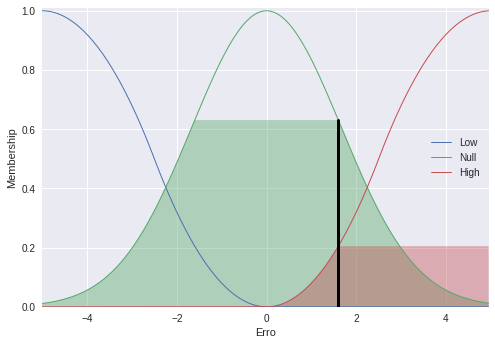

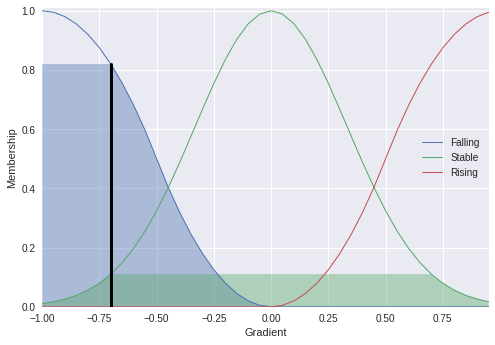

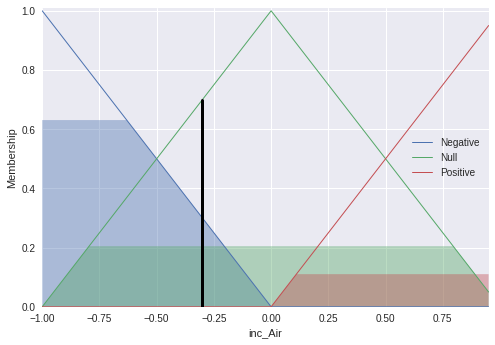

In [63]:
Control_Air.input['Erro'] = Silicium_Error
Control_Air.input['Gradient'] = Grad

# Crunch the numbers
Control_Air.compute()

print("-------------------------------")
print("For a Silicium Grade = " + str(Silicium))
print("Control Error = " + str(Silicium_Error))
print("Gradient Error = " + str(Grad))
print("The control Air increment should be = " + str(Control_Air.output['inc_Air']))
print("-------------------------------\n\n")

"""
Once computed, we can view the result as well as visualize it.
"""
Erro.view(sim=Control_Air)
Gradient.view(sim=Control_Air)
inc_Air.view(sim=Control_Air)





-------------------------------
For a Silicium Grade = 1.4
Control Error = 1.6
Gradient Error = -0.7000000000000002
The control Level increment should be = 2.863378761726077
-------------------------------




/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


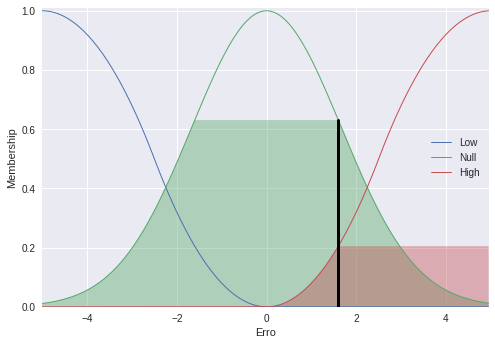

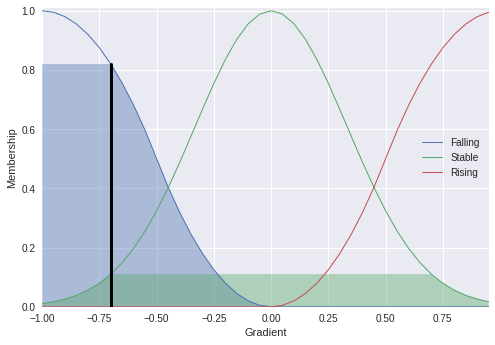

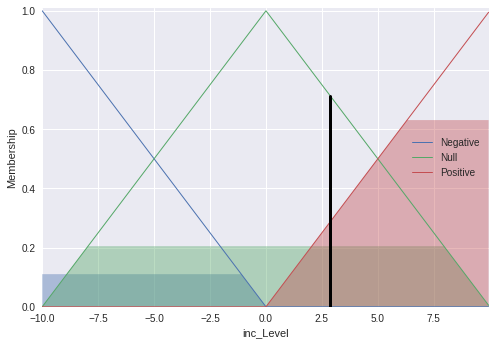

In [65]:
Control_Level.input['Erro'] = Silicium_Error
Control_Level.input['Gradient'] = Grad

# Crunch the numbers
Control_Level.compute()

print("-------------------------------")
print("For a Silicium Grade = " + str(Silicium))
print("Control Error = " + str(Silicium_Error))
print("Gradient Error = " + str(Grad))
print("The control Level increment should be = " + str(Control_Level.output['inc_Level']))
print("-------------------------------\n\n")

"""
Once computed, we can view the result as well as visualize it.
"""
Erro.view(sim=Control_Level)
Gradient.view(sim=Control_Level)
inc_Level.view(sim=Control_Level)

In [0]:
"""# We can simulate at higher resolution with full accuracy
upsampled = np.linspace(0.1, 10, 21)
x = upsampled #np.meshgrid(upsampled, upsampled)
upsampled = np.linspace(0.1, 25, 21)
y = upsampled #np.meshgrid(upsampled, upsampled)
z = np.zeros_like(np.meshgrid(x, y))

print(x)
print(y)
print(z)
           
        
# Loop through the system 21*21 times to collect the control surface
for i in range(21):
    for j in range(21):
        
        #print(y[i])
        tipping.input['Silica'] = (x)
        tipping.input['Ferro'] = (y[j])
        tipping.compute()
        test = tipping.output['inc_Amina']
        
        print(test)
        z[i][j] = np.float(test)

# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)
"""


"# We can simulate at higher resolution with full accuracy\nupsampled = np.linspace(0.1, 10, 21)\nx = upsampled #np.meshgrid(upsampled, upsampled)\nupsampled = np.linspace(0.1, 25, 21)\ny = upsampled #np.meshgrid(upsampled, upsampled)\nz = np.zeros_like(np.meshgrid(x, y))\n\nprint(x)\nprint(y)\nprint(z)\n           \n        \n# Loop through the system 21*21 times to collect the control surface\nfor i in range(21):\n    for j in range(21):\n        \n        #print(y[i])\n        tipping.input['Silica'] = (x)\n        tipping.input['Ferro'] = (y[j])\n        tipping.compute()\n        test = tipping.output['inc_Amina']\n        \n        print(test)\n        z[i][j] = np.float(test)\n\n# Plot the result in pretty 3D with alpha blending\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting\n\nfig = plt.figure(figsize=(8, 8))\nax = fig.add_subplot(111, projection='3d')\n\nsurf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',